## Q.1.1: Simulating the ARMA Process

In [80]:
def ar(p, df):
    df_temp = df
    
    for i in range(1, p+1):
        df_temp['Shifted_values_%d' % i ] = df['Value'].shift(i)
    train_size = (int)(0.8 * df_temp.shape[0])
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])
    
    
    df_train = df_train.dropna()
    
    X_train = df_train.iloc[:,1:].values.reshape(-1,p)

    y_train = df_train.iloc[:,0].values.reshape(-1,1)
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    
    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_


    return [df_train,df_test,theta,intercept]


In [81]:
def ma(q, res):
    for i in range(1,q+1):
        res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

    train_size = (int)(0.8 * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    res_train = res_train.dropna()
    X_train = res_train.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train.iloc[:,0].values.reshape(-1,1)

    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    res_train['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

    X_test = res_test.iloc[:,1:].values.reshape(-1,q)
    res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
    

    return [res_train,res_test,theta,intercept]

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(12345)

def generate_arma_samples(p,q,period):
    random_values = np.random.standard_normal(size = period)
    df = pd.DataFrame(random_values, columns=['Value'])
    results = ar(p,df)
    df_train = results[0]
    df_test = results[1]
    theta_1 = results[2]
    intercept_1 = results[3]
    
    df_c = pd.concat([df_train,df_test])
    res = pd.DataFrame()
    res['Residuals'] = df_c.Value - df_c.Predicted_Values
    
    if(q == 0):
        return df_c['Predicted_Values']
    final_result = ma(q, res)
    df_train = final_result[0]
    df_test = final_result[1]
    theta_2 = results[2]
    intercept_2 = results[3]
    
    df_c_new = pd.concat([df_train,df_test])

    predictions = df_c['Predicted_Values'] + df_c_new['Predicted_Values']
    return predictions

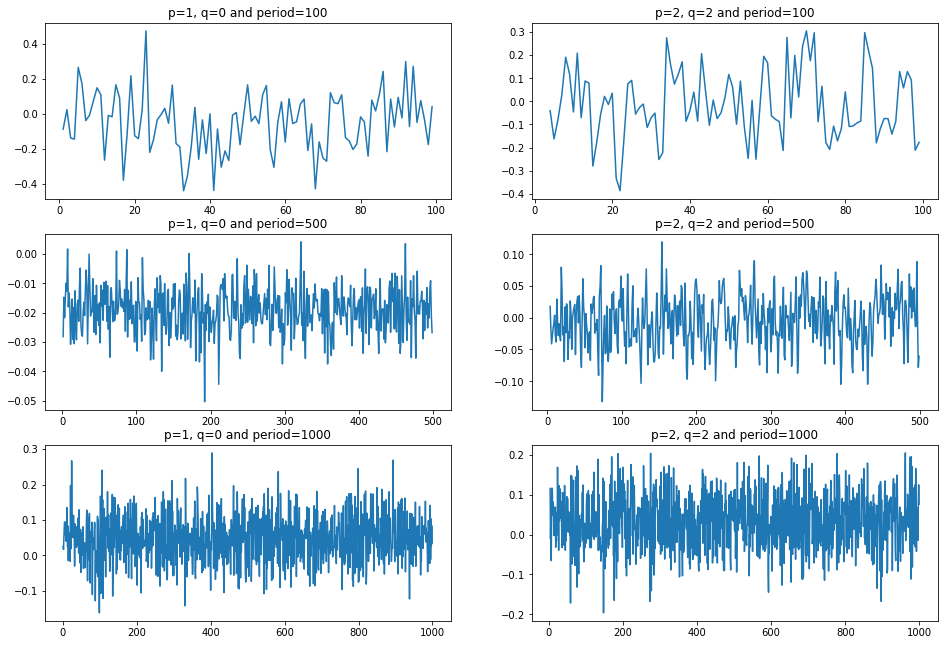

In [83]:
T = [100, 500, 1000]
plt.rcParams["figure.figsize"] = (16,11)
for i in range(len(T)):
    
    
    predictions = generate_arma_samples(1,0,T[i])

    plt.subplot(3, 2, i*2+1)
    plt.plot(predictions)
    plt.title("p=1, q=0 and period=" + str(T[i]))
    
    predictions = generate_arma_samples(2,2,T[i])
    
    plt.subplot(3, 2, i*2+2)
    plt.plot(predictions)
    plt.title("p=2, q=2 and period=" + str(T[i]))

plt.show()

final_data = generate_arma_samples(2 , 2 , 1000)

Gaussian Random noise can be added but I wanted to show that the series are different and data generated is not the same. 

In [5]:
gaussian_random_noise = np.random.normal(size=100)
gaussian_random_noise

array([-0.26073712, -1.26786263, -0.13469471, -0.51723138, -0.34039422,
        1.08922844,  0.12935723,  1.02236187, -0.44393185, -0.65463514,
        0.34730575, -1.13472737,  0.23754851, -0.6679466 ,  2.66786394,
        0.73679506, -2.66583148, -0.0979965 ,  1.19646589, -0.1217935 ,
        0.37943765,  1.31925246,  1.55375081,  0.94841878,  0.84865634,
        0.64249191, -0.99681585,  0.42790948,  0.62218054, -1.90391682,
        0.83741013,  0.9165679 , -0.47616716,  0.502366  ,  0.48926101,
        0.19522602,  0.44030136, -0.7498581 ,  0.23741036,  0.94068638,
       -1.4507989 ,  0.72079032, -1.72196879,  1.32197565,  0.8593635 ,
       -0.34105428,  0.38680968, -0.35060244, -0.75166901, -0.29994558,
        0.2360629 , -0.73074665, -0.39328596, -0.67183927, -0.42488003,
       -1.12928852, -0.96597708,  0.89496131,  1.38782873, -0.70105024,
       -0.12427765, -0.20618509, -0.97842703, -0.34608573, -1.90477343,
        0.72438205, -0.45072136, -0.08033173,  0.59994746, -3.64

## Q.1.2: Things to think about

### 1: 
Let's say the we have 4 sequential observations:  

X_1, X_2, X_3, X_4 and the lag given is 2

So the X matrix has a shape of 2 * 3 and it is given as:

[[1, X_2, X_1],[1, X_3, X_2]]

and the Y matrix has a shape 2 * 1 and it is given as:

Y = [X_3, X_4]T  


--------------------------------------------------------------------  

Yt - Yt_hat = mu + N(0, sigma_squared)

E[Yt - Yt_hat] = mu

E[Yt - (theta_1 * Yt-1 + theta_2 * Yt-2 + ... + theta_p * Yt-p ) ] = mu

mu = E[Yt] * (1 - theta_1 - theta_2 - ... - theta_p) 

(refer to the attached pdf)

### 2:

The MA(q) Model assumes that the upcoming residual has some correlation with the previous residuals  
This is not completely true, as the errors are modelled to have normal distribution the correlation between the lagging terms is very very low  

There are several methods to estimate the parameters of MA model:
1) Method of Moments:

2) Least square estimation:

(refer to the attached pdf)

[1.1315998573920885, 1.1910522912161747, 1.2832258434776738, 1.4016801532884944, 1.2006134187754098, 1.2555773317320906, 1.342181795574488, 1.4547869914801344, 1.3024188887191959, 1.3521136593359437, 1.431818220176469, 1.5368705753224532, 1.4300298522396997, 1.4743867524572316, 1.5468105556732696, 1.643595198416964]


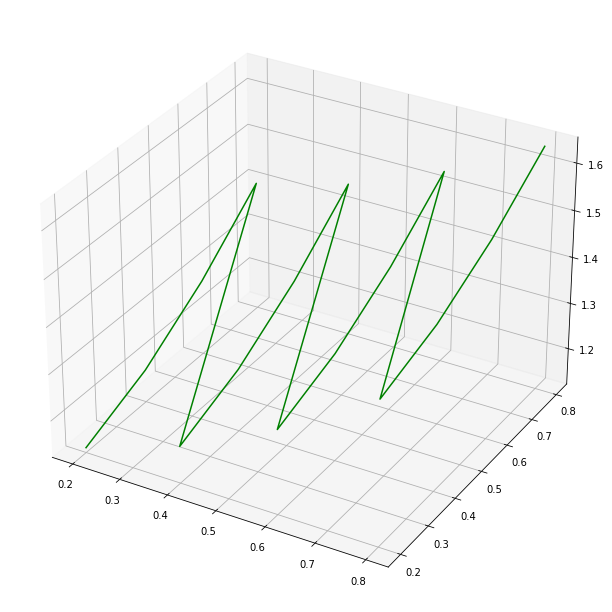

In [80]:
# Consider an MA(2) process
q = 2
theta_1 = [0.2,0.4,0.6,0.8]
theta_2 = [0.2,0.4,0.6,0.8]

random_values = np.random.standard_normal(size = 100)
res = pd.DataFrame(random_values, columns=['Residuals'])

for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

train_size = (int)(1 * res.shape[0])

res_train = pd.DataFrame(res[0:train_size])

res_train = res_train.dropna()
X_train = res_train.iloc[:,1:].values.reshape(-1,q)
y_train = res_train.iloc[:,0].values.reshape(-1,1)

from sklearn.metrics import mean_squared_error

rmse = []
for one in theta_1:
    for two in theta_2:
        arr = np.array([one, two])
        res_train['Predicted_Values'] = X_train.dot(arr.T)

        RMSE = np.sqrt(mean_squared_error(res_train['Residuals'], res_train['Predicted_Values']))
        rmse.append(RMSE)

fig = plt.figure()
ax = plt.axes(projection ='3d')

iter_new = 0

x = [0.2, 0.2, 0.2, 0.2,0.4, 0.4,0.4,0.4,0.6,0.6,0.6,0.6,0.8,0.8,0.8,0.8]
y = [0.2,0.4,0.6,0.8, 0.2,0.4,0.6,0.8, 0.2,0.4,0.6,0.8, 0.2,0.4,0.6,0.8]
ax.plot3D(x,y,rmse,'green')
"""
for one in theta_1:
    for two in theta_2:  
        ax.scatter(one, two, rmse[iter_new], 'green')
        iter_new += 1
"""
print(rmse)

As we can see from the above plot that by varying the parameters the estimation is oscillating and there's no way we can predict the direction, so we actually have to check at all values to determine the absolute minima of the model. That's why the model estimation process is a bit harder.

## 3:

The process can be determined to be long-memory process or short-memory process based on observing the rate of decay of statistical dependance between 2 points as we increase the distance between them.  
In the plot below we can see that after a certain point the magnitude of autocorrelation decays exponentially.  

That's why,The resulting ARMA Process is a short-memory process.



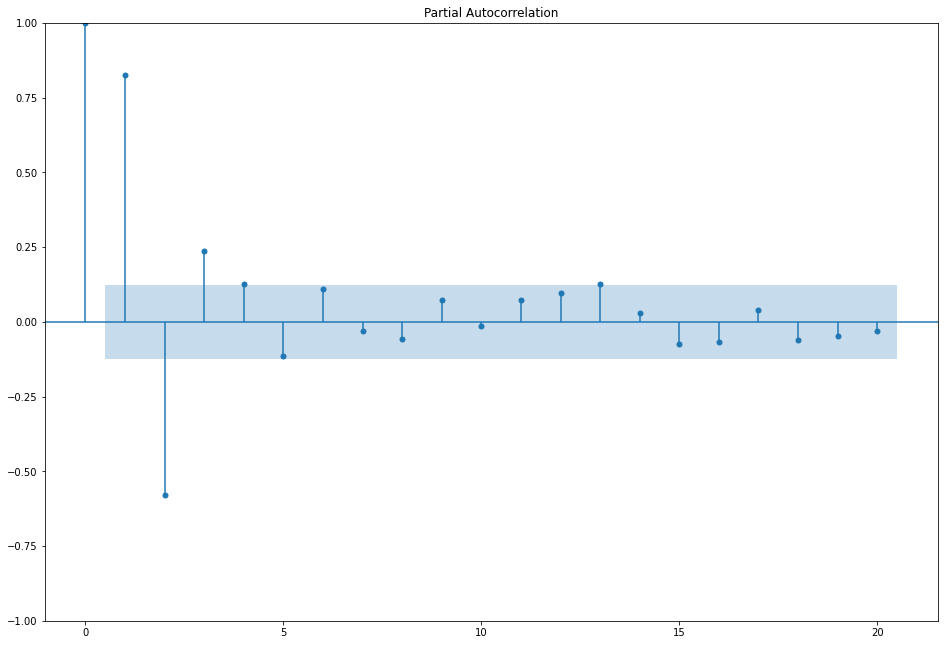

In [81]:
import statsmodels.api as sm

arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = sm.tsa.arma_generate_sample(ar, ma, 250)

sm.graphics.tsa.plot_pacf(y, lags=20, method="ywm")
plt.show()

### 4:

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

1) The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.  

2) The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

But if residuals have a mean of mu it is very easy to fix it. Just add mu to all the forecasts and thus the bias problem is solved. So I don't really think that there is any other additional benefit to have noise process with non-zero mean.

## Q.1.3: Fun with Machine Learning: 

### 1.

The loss function that can be used is RMSE, that is root mean squared error.  

RMSE = sqrt(summation(yt - yt_hat)^2 / n)

The reasons for using RMSE:  
1) Root mean squared error is an absolute error measure that squares the deviations to keep the positive and negative deviations from canceling one another out.  

2) This measure also tends to exaggerate large errors, which can help when comparing methods.

Another Interesting metric to track is bias.

bias = 1/n * summation(yt - yt_hat)

If the forecast is highly biased then there is something wrong in the model.


### 2: 

A baseline in forecast performance provides a point of comparison. It is a point of reference for all other modeling techniques on your problem. If a model achieves performance at or below the baseline, the technique should be fixed or abandoned. Before you can establish a performance baseline on your forecast problem, you must develop a test harness. This is comprised of:

1) The dataset you intend to use to train and evaluate models.
2) The resampling technique you intend to use to estimate the performance of the technique (e.g. train/test split).
3) The performance measure you intend to use to evaluate forecasts (e.g. mean squared error).

Once prepared, you then need to select a naive technique that you can use to make a forecast and calculate the baseline performance.

The technique that I am going to use is persistance algorithm. 

The dataset that we are going to use is the one that we generated in the first section with parameters p = 2, q = 2 and T = 1000  

The train/test split we are gonna do is 80:20  

And the 2 metrics we are going to observe is bias and RMSE

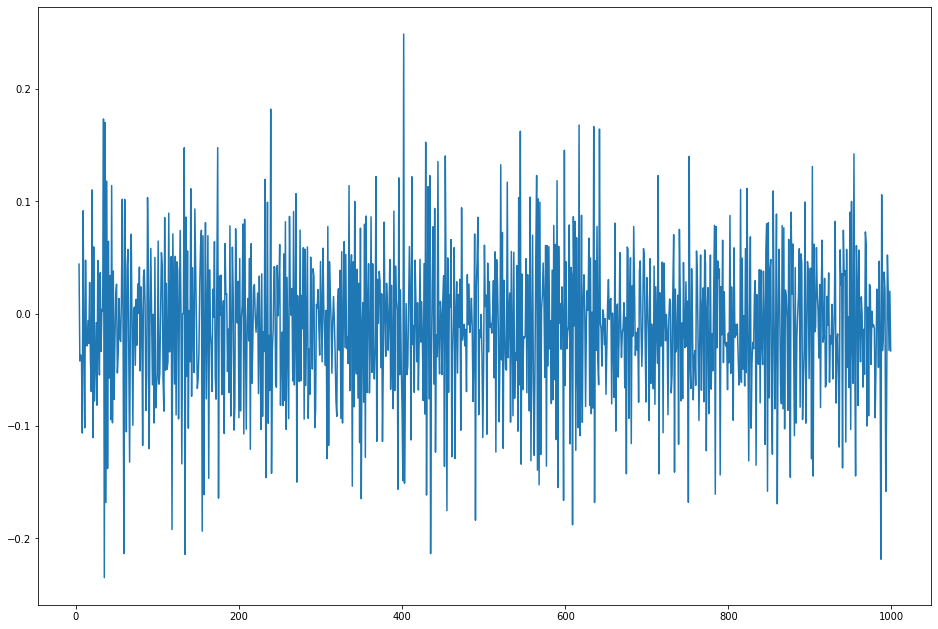

In [85]:
data = final_data

data.plot()
plt.show()

In [86]:
# Create lagged dataset
values = pd.DataFrame(data.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

        t-1       t+1
0       NaN       NaN
1       NaN       NaN
2       NaN  0.044029
3  0.044029 -0.042209
4 -0.042209 -0.036822


In [87]:
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.8)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [88]:
# persistence model
def model_persistence(x):
    return x

In [89]:
# walk-forward validation
from sklearn.metrics import mean_squared_error
import math

predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = math.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % test_score)

forecast_errors = [test_y[i]-predictions[i] for i in range(len(test_y))]
bias = sum(forecast_errors) * 1.0/len(test_y)
print('Bias: %f' % bias)

Test RMSE: 0.110
Bias: 0.000172


### 3: ARIMA Model Implementation

In [90]:
import statsmodels.api as sm

arma_data = final_data
values = pd.DataFrame(arma_data.values)
train_size = (int)(0.8 * values.shape[0])

values_train = values[0:train_size]
values_test = values[train_size:values.shape[0]]

print(len(values_train))
print(len(values_test))
model = sm.tsa.arima.ARIMA(values_train,order=(2,0,2))

model_fit = model.fit()
print(model_fit.summary())

798
200
                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  798
Model:                 ARIMA(2, 0, 2)   Log Likelihood                1167.981
Date:                Fri, 27 May 2022   AIC                          -2323.962
Time:                        17:38:06   BIC                          -2295.869
Sample:                             0   HQIC                         -2313.169
                                - 798                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0123      0.001    -18.898      0.000      -0.014      -0.011
ar.L1         -0.7239      0.510     -1.420      0.155      -1.723       0.275
ar.L2         -0.0203      0.096     -0.212 

In [91]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

history = values_train
#history = [x for x in values_train]
predictions = list()

for t in range(len(values_test)):
    model = sm.tsa.arima.ARIMA(history, order=(2,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    try:
        yhat = output[0]
    except Exception as e:
        yhat = output.values[0]
    predictions.append(yhat)
    obs = values_test[0][t+798]
    history = np.append(history,obs)

print(np.shape(values_test))
print(np.shape(predictions))

test_score = math.sqrt(mean_squared_error(values_test, predictions))
print('Test RMSE: %.3f' % test_score)


values_test = values_test.values

forecast_errors = [values_test[i] - predictions[i] for i in range(len(values_test))]
bias = sum(forecast_errors) * 1.0/len(values_test)
print('Bias: %f' % bias)

predictions_arma = predictions
test_arma = values_test

(200, 1)
(200,)
Test RMSE: 0.056
Bias: -0.002386


### 4: Feed Forward Deep Neural Network

In [92]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d])
        Y.append(data_arr[d])
    return np.array(X), np.array(Y)

In [93]:
dnn_data = final_data

train_size = 800
train, test =dnn_data.values[0:train_size],dnn_data.values[train_size:len(dnn_data.values)]

look_back = 15

trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

The activation function that i used here is tanh, first i was thinking of using relu but it doesn't account for negative values. In our series we have negative values and tanh takes care of non-linearity in the model  


In [96]:
trainX = np.nan_to_num(trainX)

In [97]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras

def model_dnn(look_back):
    model=Sequential()
    model.add(Dense(units=8, input_dim=look_back, activation='tanh'))
    model.add(Dense(4, activation='tanh'))
    model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss='mean_squared_error',  optimizer=opt,metrics = ['mse', 'mae'])
    return model

In [98]:
from keras.callbacks import EarlyStopping

model=model_dnn(look_back)

history=model.fit(trainX,trainY, epochs=100, batch_size=30, verbose=1, validation_data=(testX,testY),callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)

Epoch 1/100
27/27 [==============================] - 1s 10ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0712 - val_loss: 0.0045 - val_mse: 0.0045 - val_mae: 0.0529
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0529 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0495
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0493 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0479
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0478 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0469
Epoch 5/100
27/27 [==============================] - 0s 3ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0471 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0464
Epoch 6/100
27/27 [==============================] - 0s 3ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0468 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0461
Epoch 7/100
27/27 [==

In [99]:
 def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Test Root Mean Squared Error(RMSE): 0.06
Bias: 0.004816


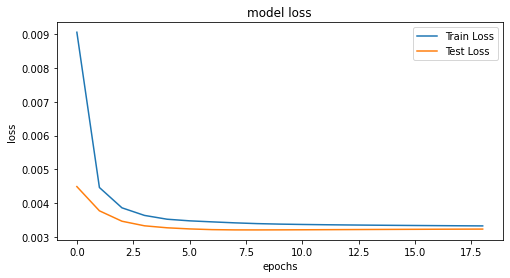

In [100]:
test_score = model.evaluate(testX, testY, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f' 
% (np.sqrt(test_score[1])))

predictions = model.predict(testX, verbose=0)

forecast_errors = [testY[i] - predictions[i] for i in range(len(testY))]
bias = sum(forecast_errors) * 1.0/len(testY)
print('Bias: %f' % bias)

predictions_dnn = predictions
test_dnn = testY

model_loss(history)

### 4. LSTM

In [101]:
lstm_data= final_data.values 
lstm_data = np.reshape(lstm_data, (-1, 1)) 

In [102]:
train_size = 800
test_size = len(lstm_data) - train_size
train, test = lstm_data[0:train_size], lstm_data[train_size:len(lstm_data)]
look_back = 30
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [103]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
def model_lstm(look_back):
    model=Sequential()
    model.add(LSTM(100, input_shape=(1, look_back), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

In [104]:
trainX = np.nan_to_num(trainX)

In [105]:
model=model_lstm(look_back)

history = model.fit(trainX, trainY, epochs=100, batch_size=30, validation_data=(testX, testY), callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Epoch 1/100
26/26 [==============================] - 2s 17ms/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0553 - val_loss: 0.0045 - val_mse: 0.0045 - val_mae: 0.0541
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0532 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0529
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0515 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0518
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0500 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0507
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0485 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0498
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0472 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0490
Epoch 7/100
26/26 [==

Test Root Mean Squared Error(RMSE): 0.06 
Bias: 0.003490


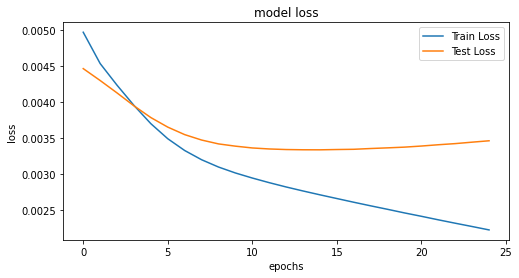

In [106]:
test_predict = model.predict(testX)

print('Test Root Mean Squared Error(RMSE): %.2f '% (np.sqrt(mean_squared_error(testY, test_predict))))

forecast_errors = [testY[i] - test_predict[i] for i in range(len(testY))]
bias = sum(forecast_errors) * 1.0/len(testY)
print('Bias: %f' % bias)

predictions_lstm = test_predict
test_lstm = testY
model_loss(history)

The LSTM rectifies a huge issue that recurrent neural networks suffer from: short-memory. Using a series of ‘gates,’ each with its own RNN, the LSTM manages to keep, forget or ignore data points based on a probabilistic model.  

The different gates inside LSTM boost its capability for capturing non linear relationships for forecasting. Causal factors generally have non-linear impact on demand. When these factors are used as part of the input variable, the LSTM could learn the nonlinear relationship for forecasting.

### 5: Comparison of models

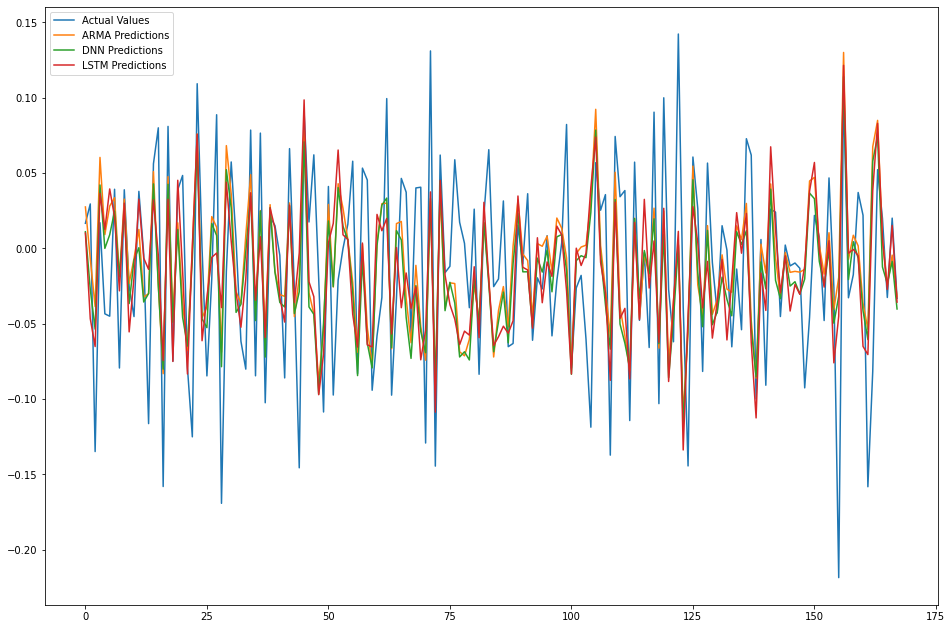

In [107]:
actual_values = test_lstm

arma_predictions = predictions_arma[len(predictions_arma) - 168:]
dnn_predictions = predictions_dnn[len(predictions_dnn) - 168:]
lstm_predictions = predictions_lstm

plt.plot(actual_values, label = "Actual Values")
plt.plot(arma_predictions, label = "ARMA Predictions")
plt.plot(dnn_predictions, label = "DNN Predictions")
plt.plot(lstm_predictions, label = "LSTM Predictions")

plt.legend()
plt.show()

## Q.1.4: Fun with Tensorflow

### 1:

1) Automatic differentiation is useful for implementing machine learning algorithms such as backpropagation for training neural networks.  
2) To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the forward pass. Then, during the backward pass, TensorFlow traverses this list of operations in reverse order to compute gradients.  
3) TensorFlow provides the tf.GradientTape API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually tf.Variables. TensorFlow "records" relevant operations executed inside the context of a tf.GradientTape onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

### 2:

In [109]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

final_data.dropna(inplace=True)
df = pd.DataFrame(final_data.values, columns=['Value'])
print(df.head(5))
df_temp = df
p = 2
for i in range(1, p+1):
    df_temp['Shifted_values_%d' % i ] = df['Value'].shift(i)

df_train = df_temp   
df_train = df_train.dropna()
    
X_train = df_train.iloc[:,1:].values.reshape(-1,p)
y_train = df_train.iloc[:,0].values.reshape(-1,1)

      Value
0  0.044029
1 -0.042209
2 -0.036822
3 -0.038047
4 -0.106319


In [110]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

dtype = tf.float32
X = tf.constant(X_train, dtype=dtype)
Y = tf.constant(y_train, dtype=dtype)
print(X_train.shape)
print(y_train.shape)
pi = tf.constant(np.pi, dtype=dtype)


(994, 2)
(994, 1)


In [111]:
@tf.function
def neg_ols_loglike(param_vec):
    beta_split, sigma_split = tf.split(param_vec, [2,1], axis=0)
    beta_split = tf.reshape(beta_split,(2,))
    sigma_split = tf.reshape(sigma_split,())
    mu = tf.linalg.matvec(X, beta_split)
    ll =  -(X.shape[0]/2.)*tf.math.log(2.*pi*sigma_split**2.) -(1./(2.*sigma_split**2.))*tf.math.reduce_sum((Y-mu)**2., axis=None)
    return -1*ll

# return function value and gradients
@tf.function
def neg_like_and_gradient(parms):
    return tfp.math.value_and_gradient(neg_ols_loglike, parms)

# using the same values as above
testval = tf.constant([1., 1., 1.], shape=(3))
out = neg_like_and_gradient(parms=testval)
print("Function value: ", out[0])
print("Gradients: ", out[1])

Function value:  tf.Tensor(5676.283, shape=(), dtype=float32)
Gradients:  tf.Tensor([ 2504.4504  2506.2815 -8531.717 ], shape=(3,), dtype=float32)


In [112]:
# set some naiive starting values
start = [0.5, 0.5, 1.]

# optimization
optim_results = tfp.optimizer.bfgs_minimize(neg_like_and_gradient, start, tolerance=1e-8)

# organize results
est_params = optim_results.position.numpy()
est_serr = np.sqrt(np.diagonal(optim_results.inverse_hessian_estimate.numpy()))
print(pd.DataFrame(np.c_[est_params, est_serr],columns=['estimate', 'std err'],index=['b0', 'b1', 'sigma']))

       estimate   std err
b0     0.058484  0.033893
b1     0.058428  0.031558
sigma  2.199299  0.048605
